In [1]:
import argparse
import os
import random
import numpy as np
import torch
import torch.backends.cudnn as cudnn
from PIL import Image

from skingpt4.common.config import Config
from skingpt4.common.dist_utils import get_rank
from skingpt4.common.registry import registry
from skingpt4.conversation.conversation import Chat, CONV_VISION

# imports modules for registration
from skingpt4.datasets.builders import *
from skingpt4.models import *
from skingpt4.processors import *
from skingpt4.runners import *
from skingpt4.tasks import *

/home/jq2uw/miniconda3/envs/skingpt4_llama2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def setup_seeds(config):
    seed = config.run_cfg.seed + get_rank()
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    cudnn.benchmark = False
    cudnn.deterministic = True

# Initialize model with the correct config path
config_path = "eval_configs/skingpt4_eval_llama2_13bchat.yaml"  # llama
# config_path ='eval_configs/skingpt4_eval_vicuna.yaml' # vicuna
gpu_id = 0  # Update if using different GPU

# Create args object
class Args:
    def __init__(self):
        self.cfg_path = config_path
        self.gpu_id = gpu_id
        self.options = None

args = Args()
cfg = Config(args)

# Initialize model
print('Initializing Chat')
model_config = cfg.model_cfg
model_config.device_8bit = args.gpu_id
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to('cuda:{}'.format(args.gpu_id))

vis_processor_cfg = cfg.datasets_cfg.cc_sbu_align.vis_processor.train
vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)
chat = Chat(model, vis_processor, device='cuda:{}'.format(args.gpu_id))
print('Initialization Finished')

Initializing Chat
Loading VIT
Loading VIT Done
Loading Q-Former
Loading Q-Former Done
Loading LLM tokenizer
Loading LLM model


Loading checkpoint shards: 100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Loading LLM Done
Load 2 training prompts
Prompt Example 
###Human: <Img><ImageHere></Img> Could you describe the skin disease in this image for me? ###Assistant: 
Load BLIP2-LLM Checkpoint: /scratch/jq2uw/edit-skingpt4/model_skingpt4/weights/skingpt4_llama2_13bchat_finetune_v4.2_small_class.pth
Initialization Finished


In [3]:
def process_image_and_chat(image_path, question, num_beams=1, temperature=1.0):
    """
    Process an image and ask a question about it.
    
    Args:
        image_path: Path to the image file
        question: Question to ask about the image
        num_beams: Number of beams for generation (default: 1)
        temperature: Temperature for generation (default: 1.0)
    
    Returns:
        The model's response
    """
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    
    # Initialize conversation
    chat_state = CONV_VISION.copy()
    img_list = []
    
    # Upload image
    llm_message = chat.upload_img(image, chat_state, img_list)
    
    # Ask question
    chat.ask(question, chat_state)
    
    # Get answer
    response = chat.answer(
        conv=chat_state,
        img_list=img_list,
        num_beams=num_beams,
        temperature=temperature,
        max_new_tokens=300,
        max_length=2000
    )[0]
    
    return response

def chat_with_image(image, question, num_beams=1, temperature=1.0):
    """
    Chat with an already loaded PIL Image object.
    
    Args:
        image: PIL Image object
        question: Question to ask about the image
        num_beams: Number of beams for generation (default: 1)
        temperature: Temperature for generation (default: 1.0)
    
    Returns:
        The model's response
    """
    # Initialize conversation
    chat_state = CONV_VISION.copy()
    img_list = []
    
    # Upload image
    llm_message = chat.upload_img(image, chat_state, img_list)
    
    # Ask question
    chat.ask(question, chat_state)
    
    # Get answer
    response = chat.answer(
        conv=chat_state,
        img_list=img_list,
        num_beams=num_beams,
        temperature=temperature,
        max_new_tokens=300,
        max_length=2000
    )[0]
    
    return response

In [4]:
# Example 1: Process image from file path
image_path = "../data/s-prd-396524710.jpg"  # Update this path
question = "What do you see in this skin image? Please provide a detailed analysis."

response = process_image_and_chat(image_path, question)
print("Question:", question)
print("Response:", response)

Question: What do you see in this skin image? Please provide a detailed analysis.
Response: This is an image of a person's arm with a large mosquito bite on the forearm. The bite appears to be infected, with redness and swelling around the area. There are also small pustules or blisters on the surface of the bite. The rest of the image shows the person's skin, which appears to be smooth and unblemished.


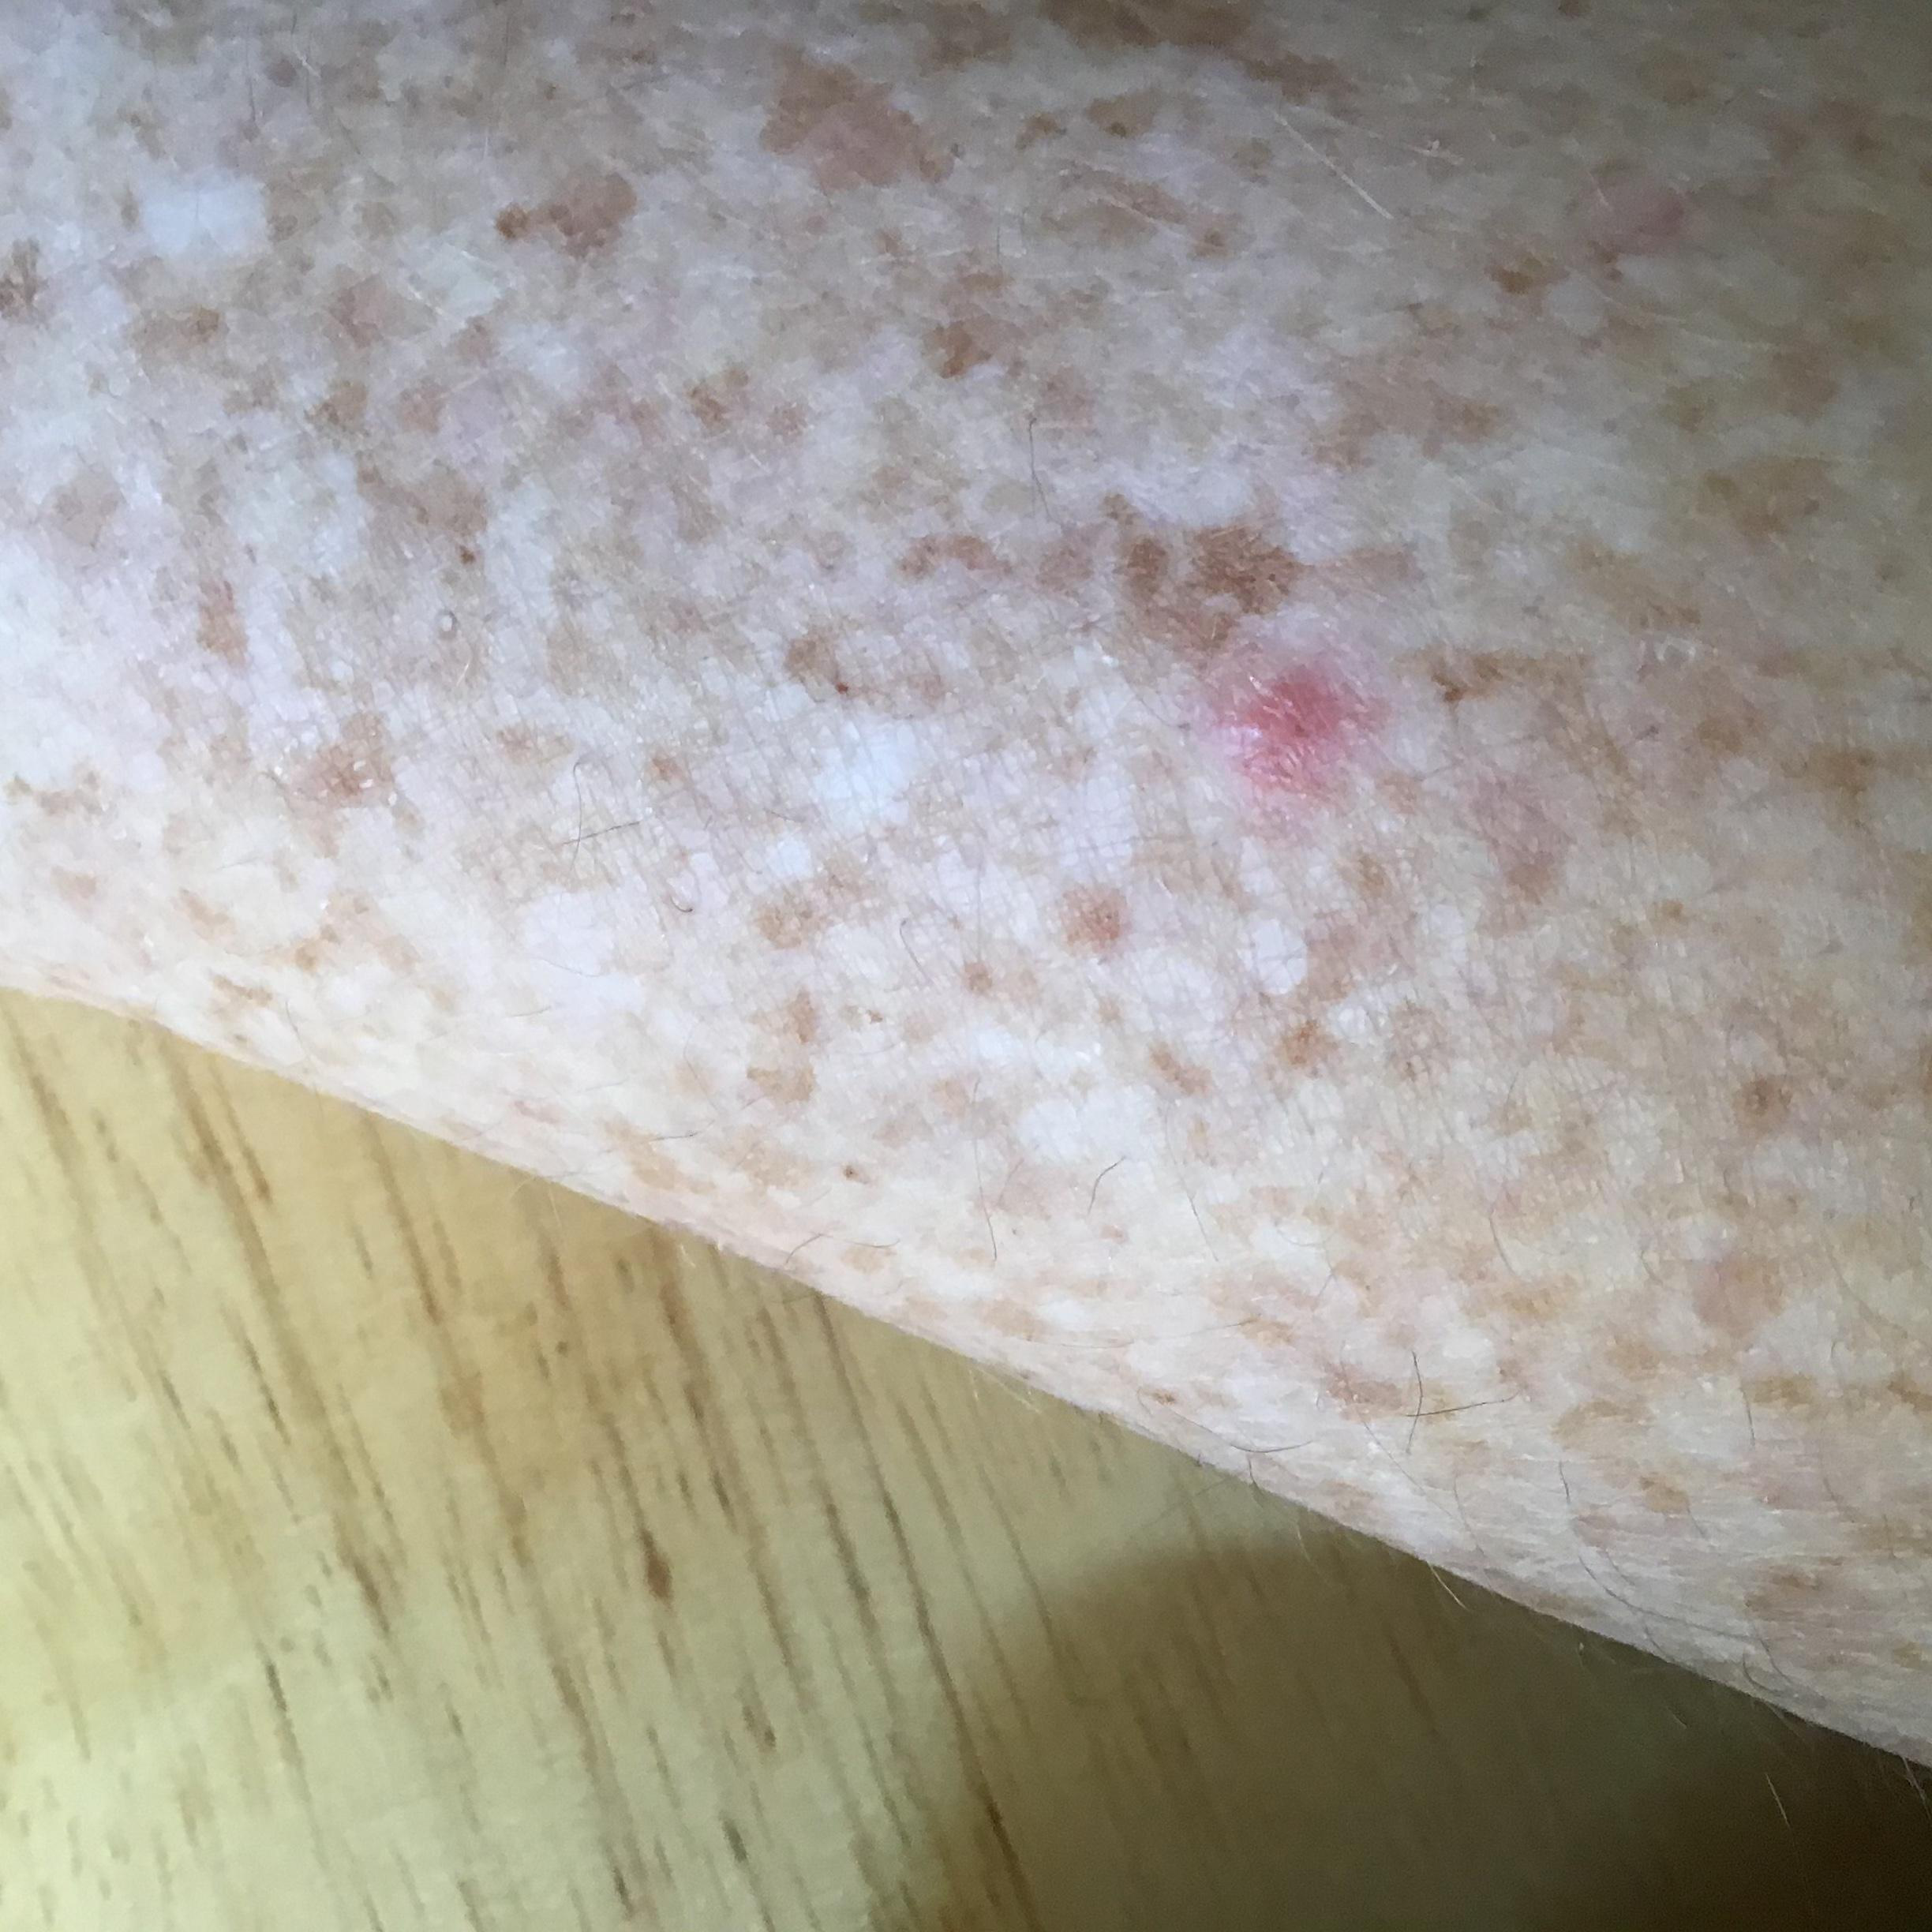

--------------------------------------------------

Q: What do you see in this skin image?
--------------------------------------------------
A: This is an image of a person's arm, with visible veins and other skin features. The skin appears to be healthy and unblemished, with no signs of irritation or infection. The veins are prominent and well defined, indicating good circulation and overall vascular health. Overall, this image suggests that the person's skin is in good condition.
--------------------------------------------------

Q: Are there any concerning features?
--------------------------------------------------
A: The image shows a close up view of a person's arm, with a small red bump on the wrist. The skin appears smooth and unblemished, with a few small freckles scattered across it. There are also a few small scratches or imperfections on the surface of the skin. The overall appearance is of healthy, unblemished skin.
--------------------------------------------------

Q: 

In [5]:
from IPython.display import display
import matplotlib.pyplot as plt

# Load and display image
image = Image.open("../data/s-prd-396524710.jpg")  # Update this path
display(image)

# Ask questions about the image
questions = [
    "What do you see in this skin image?",
    "Are there any concerning features?",
    "What would you recommend regarding this skin condition?"
]

for question in questions:
    response = chat_with_image(image, question)
    print("-" * 50)
    print(f"\nQ: {question}")
    print("-" * 50)
    print(f"A: {response}")